Using R for supervised learning
----
    
This notebook goes over the basic concept of how to construct and use a supervised learning pipleine for classificaioon. We will use the k-nearest neighbors algorithm for illustration, but the baisc ideas carry over to all algorithms for classificaiton and regression. 

In [1]:
healthdy <- read.table('healthdy.txt', header = TRUE)

In [2]:
head(healthdy)

,ID,GENDER,FLEXPRE,FLEXPOS,BAWPRE,BAWPOS,BWWPRE,BWWPOS,BFPPRE,BFPPOS,FVCPRE,FVPOS,METSPRE,METSPOS
1,0,1,21.000,21.500,70.5,75.6,3.3,3.7,14.58,14.17,5.1,5.1,12.7,18.0
2,2,1,21.000,21.250,71.3,70.7,3.2,3.6,16.79,13.95,4.3,4.3,11.1,12.0
3,3,1,21.500,20.000,64.5,66.6,4.1,4.0,6.6,08.98,4.5,4.5,15.3,16.7
4,4,1,23.000,23.375,97,95.0,4.4,4.3,18.04,17.32,4.7,4.3,12.0,17.5
5,5,1,21.000,21.000,71,73.2,3.7,3.8,11.12,11.50,5.8,5.8,12.2,12.2
6,6,1,20.500,20.750,72.5,73.1,3.1,3.4,17.88,16.22,4.3,4.3,11.1,10.0


### Supervised learning problem

For simplicity and ease of visualization, we will just use the first 2 indepdendent variables as fearures for predicitng gender. In practice, the selection of approprieate features to use as predictors can be a challenging problem that greatly affects the effectiveness of supervised learning.

So the problme is: How accurately can we guess the gender of a student from the Flexpre and Bawpre variables? 

Visualizing the data
----

First let's make a smaller dataframe containing just the variables of interest, and make some plots.

In [62]:
df <- healthdy[,c("ID", "GENDER", "FLEXPRE", "BAWPRE")]
df$ID <- factor(df$ID)
df$GENDER <- factor(df$GENDER, labels = c("Male", "Female"))
df$FLEXPRE <- as.numeric(df$FLEXPRE)

In [63]:
summary(df)

       ID         GENDER       FLEXPRE          BAWPRE     
 0      :  2   Male  : 82   Min.   : 1.00   Min.   :35.20  
 2      :  2   Female:100   1st Qu.:26.00   1st Qu.:57.73  
 3      :  2                Median :42.00   Median :65.05  
 4      :  2                Mean   :38.76   Mean   :66.99  
 5      :  2                3rd Qu.:52.00   3rd Qu.:74.50  
 6      :  2                Max.   :67.00   Max.   :98.50  
 (Other):170                                               

Let's check the mean flexibilitiy and weights for boys and girls.

In [64]:
with(df, aggregate(df[,3:4], by=list(Gender=GENDER), FUN=mean))

,Gender,FLEXPRE,BAWPRE
1,Male,33.46341,75.89024
2,Female,43.1,59.695


On average, girls are more flexible and weigh less than boys. This is confirmed viually.

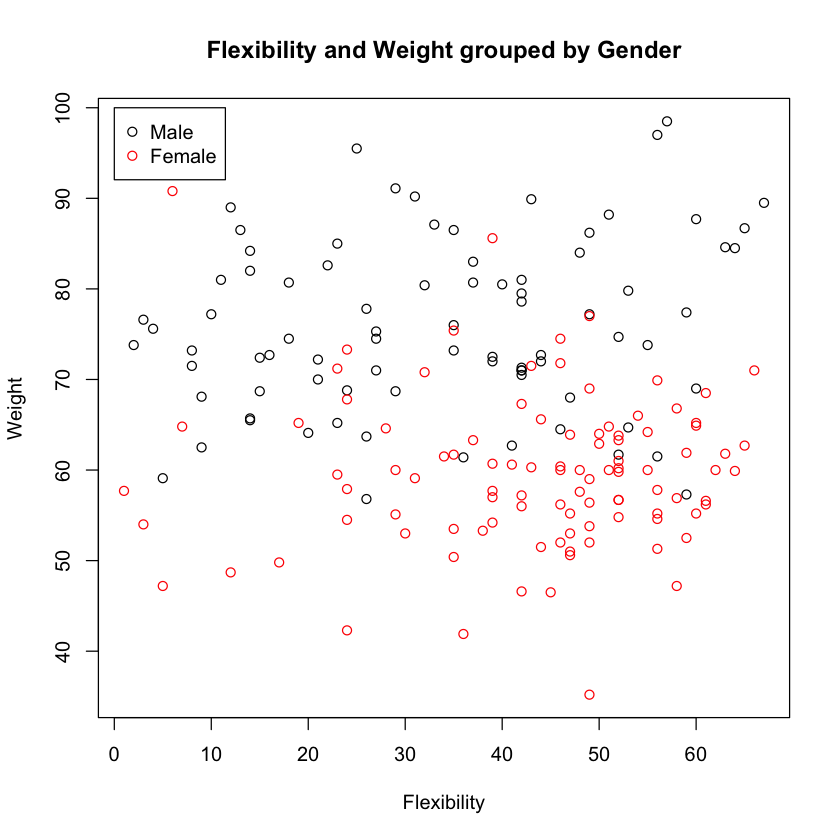

In [65]:
plot(df$FLEXPRE, df$BAWPRE, col=df$GENDER,
     xlab="Flexibility", ylab="Weight", 
     main="Flexibility and Weight grouped by Gender")
legend(0, 100, c("Male", "Female"), pch=1, col=1:2)

### Comments

It looks like there is a pretty good probablility that we can guess the gender from the body weight and flexibilty alone. The k-nearest neighbor does this guessing in a very simple fashion - Given any point in the data set, it looks for the nearest k neighboring points, and simply uses the majority gender among these neighbors as the guess. In the sections below, we'll implement a supervised learnign pipeline using k-nearest neighbors.

Work!
----

Review questions to make sure you are up to speed with basic data manipulation and plotting.

**Q1**. Tabulate the median value of FLEXPRE and BAWPRE by gender.

**Q2**. Tabluate the average change in weight from the beginnig to the end of the semester by gender.

**Q3**. Identify from the plot above the IDs of 3 individuals for whom you expect k-nearest neighbors to make the wrong gender prediction. HInt: Make a scatterplot but add the IDs as labels for each point, using a small x-offset of 2.5 so that labels are immediately to the right of each point.

Splitting data into training and test data sets
----

We will use 3/4 of the data to train the algorithm and 1/4 to test.

In [95]:
set.seed(123) # set ranodm number seed for reproducibility
size <- floor(0.75 * nrow(df)) # desired size of training set
df <- df[sample(nrow(df), replace = FALSE),] # shuffle rows randomly
df.train <- df[1:size, ] # take first size rows of shuffled data frame as training set
df.test <- df[(size+1):nrow(df), ] # take the remaining rows as the test set
x.train <- df.train[,c("FLEXPRE", "BAWPRE")]
y.train <- df.train[,"GENDER"]
x.test <- df.test[,c("FLEXPRE", "BAWPRE")]
y.test <- df.test[,"GENDER"]

In [96]:
summary(df.train)

       ID         GENDER      FLEXPRE          BAWPRE     
 2      :  2   Male  :58   Min.   : 1.00   Min.   :35.20  
 4      :  2   Female:78   1st Qu.:24.75   1st Qu.:57.67  
 5      :  2               Median :42.00   Median :64.75  
 7      :  2               Mean   :38.37   Mean   :66.20  
 8      :  2               3rd Qu.:52.00   3rd Qu.:73.42  
 10     :  2               Max.   :67.00   Max.   :97.00  
 (Other):124                                              

In [97]:
summary(df.test)

       ID        GENDER      FLEXPRE          BAWPRE     
 45     : 2   Male  :24   Min.   : 3.00   Min.   :46.60  
 49     : 2   Female:22   1st Qu.:31.75   1st Qu.:59.33  
 59     : 2               Median :43.00   Median :70.50  
 68     : 2               Mean   :39.91   Mean   :69.34  
 0      : 1               3rd Qu.:49.75   3rd Qu.:80.10  
 1      : 1               Max.   :65.00   Max.   :98.50  
 (Other):36                                              

Train knn on training set
----

In [101]:
library(class)
y.pred <- knn(x.train, x.test, cl=y.train, k=3)

In [102]:
y.pred

[1] Male   Male   Female Female Male   Female Female Male   Male   Male  
[11] Male   Female Female Male   Male   Female Male   Male   Male   Female
[21] Female Male   Female Female Female Female Male   Female Female Female
[31] Male   Male   Female Female Male   Female Female Male   Female Male  
[41] Female Female Male   Male   Male   Male  
Levels: Male Female

Evaluate the model
----

In [103]:
table(y.pred, y.test)

        y.test
y.pred   Male Female
  Male     21      2
  Female    3     20

### Who was predicted wrongly?

In [112]:
misses <- y.pred != y.test

In [113]:
df.test[misses,]

,ID,GENDER,FLEXPRE,BAWPRE
65,65,Male,29,68.7
77,77,Male,36,61.4
149,66,Female,6,90.8
21,21,Male,52,61.7
147,64,Female,49,77


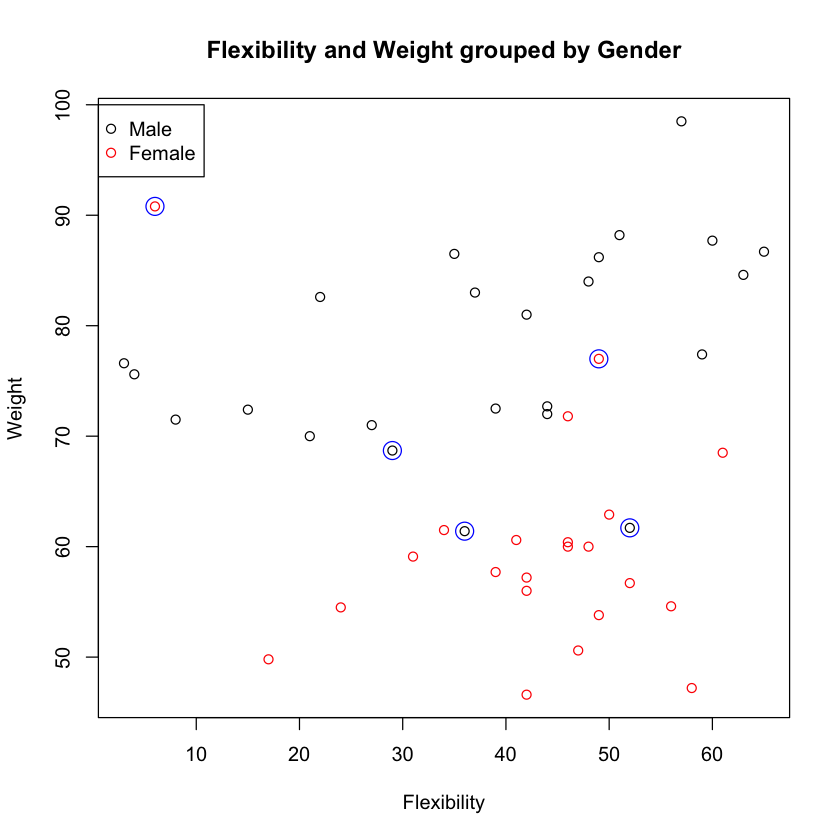

In [116]:
plot(df.test$FLEXPRE, df.test$BAWPRE, col=df.test$GENDER,
     xlab="Flexibility", ylab="Weight", 
     main="Flexibility and Weight grouped by Gender")
points(df.test$FLEXPRE[misses], df.test$BAWPRE[misses], col="blue", cex=2)

legend(0, 100, c("Male", "Female"), pch=1, col=1:2)

Work!
----

Repeat the analysis using the Bfppre and Fvcpre variables as predictors instead. Do you get better or worse predictions?

**Q!**. Extract the relevant variables into a new data frame.

**Q2**. Visualize Bfppre and Fvcpre grouped by gender.

**Q3**. Split the data into training and test data sets using a 2/3, 1/3 ratio.

**Q4**. Find the predictions make by knn with 5 neighbors.

**Q5**.. Make a table of true positives, false positives, true negatives and false negatives. Calculate

1. accuracy
2. sensitivity
3. specificity
4. possitive predicrvie value
5. negative predictive value
6. f-score (harmonic mean of senistivity and specificity)

Look up definitions in Wikipedia if you don't know what these mean.

**Q6** Make a plot to identify mis-classified subjects if any.